In [1341]:
# import some basic tools and configurations
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}});

In [1342]:
# load the dataset and look around
data = pd.read_csv('kc_house_data.csv')

display(data.head())

len_before = len(data)
print("Dataset size: {}".format(len_before))

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Dataset size: 21597


In [1343]:
# a quick check for duplicate entries
data.duplicated().any()

False

## NaNs
In `waterfront`, `view`, and `yr_renovated`

In [1344]:
print('NaN locations:')
data.isna().sum()

NaN locations:


id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Waterfront NaNs: 2376


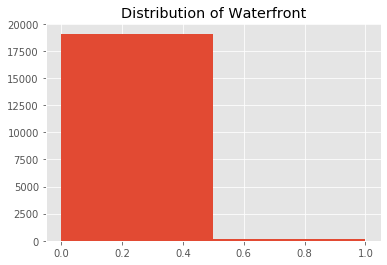

In [1345]:
print('Waterfront NaNs: {}'.format(data['waterfront'].isna().sum()))
data['waterfront'].hist(bins=2).set_title('Distribution of Waterfront');

In [1346]:
data['waterfront'].fillna(0, inplace=True)

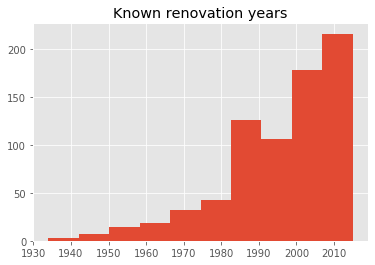

In [1347]:
data['yr_renovated'].fillna(0, inplace=True)
data['yr_renovated'] = data['yr_renovated'].astype(int)
data[data['yr_renovated'] > 0]['yr_renovated'].hist().set_title('Known renovation years');

View NaNs: 63


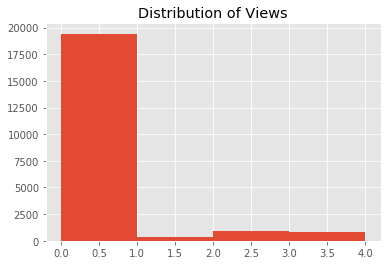

In [1348]:
print('View NaNs: {}'.format(data['view'].isna().sum()))
data['view'].hist(bins=4).set_title('Distribution of Views');

In [1349]:
data.dropna(inplace=True)

# count the datapoints lost in cleaning
print('Dataset Size\nBefore: {}\t After: {}\t Difference: {}'.format(
    len_before, len(data), (len_before - len(data))))

Dataset Size
Before: 21597	 After: 21534	 Difference: 63


In [1350]:
display(data['sqft_basement'].value_counts())
ph_count = len(data[data['sqft_basement'] == '?'])
print("Placeholders in `sqft_basement`: {}".format(ph_count))

0.0       12798
?           452
600.0       216
500.0       209
700.0       207
          ...  
768.0         1
243.0         1
3260.0        1
2120.0        1
2300.0        1
Name: sqft_basement, Length: 302, dtype: int64

Placeholders in `sqft_basement`: 452


In [1336]:
# sqft basement can be inferred by sqft_living - sqft_above
data.loc[data['sqft_basement'] == '?','sqft_basement'] = data.loc[
    data['sqft_basement'] == '?','sqft_living'] - data.loc[
    data['sqft_basement'] == '?','sqft_above']
data['sqft_basement'] = data['sqft_basement'].astype(float)
display(data['sqft_basement'].value_counts())

0.0       13080
600.0       220
700.0       217
500.0       214
800.0       206
          ...  
1920.0        1
1930.0        1
1245.0        1
588.0         1
935.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [1210]:
# a few dtypes to change
data['waterfront'] = data['waterfront'].astype(int)
data['view'] = data['view'].astype(int)
data['sqft_basement'] = data['sqft_basement'].astype(float).astype(int)

In [1211]:
# I'll make a copy of the dataset to apply changes to as I decide on them
df = data.copy()
# now let's look at the features
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [1212]:
# first we'll work on continuous features, then quantized features

data_continuous = data[['sqft_living','sqft_lot','sqft_above',
                        'sqft_basement','yr_built','yr_renovated',
                        'sqft_living15','sqft_lot15']]

data_quantized = data[['bedrooms','bathrooms','floors',
                       'view','grade','condition']]

### Check distributions and linearity of relationship

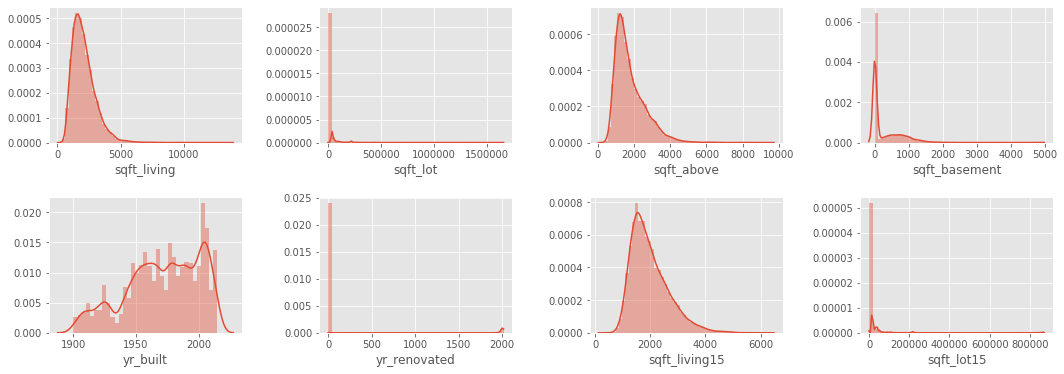

In [1213]:
fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,col in enumerate(data_continuous.columns):
    ax = fig.add_subplot(2, 4, i+1)
    sns.distplot(data_continuous[col],ax=ax)
plt.show()

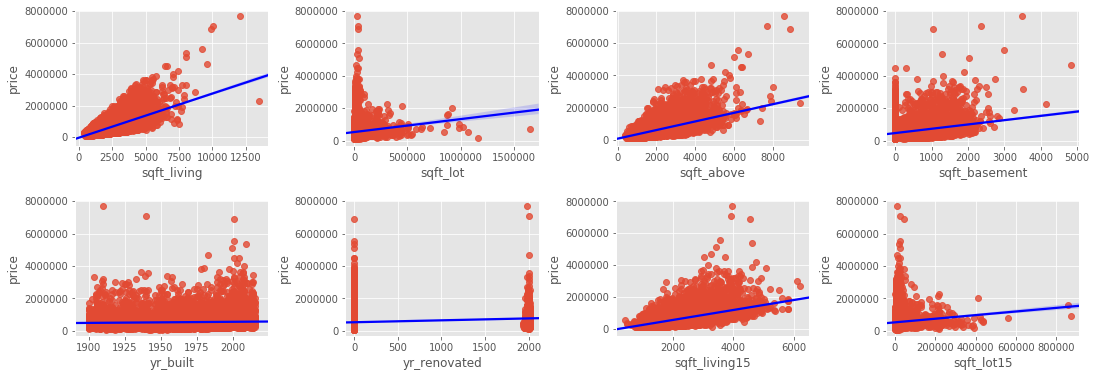

In [1214]:
fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,col in enumerate(data_continuous.columns):
    ax = fig.add_subplot(2, 4, i+1)
    sns.regplot(data_continuous[col],data['price'],ax=ax,line_kws={'color': 'blue'})
plt.show()

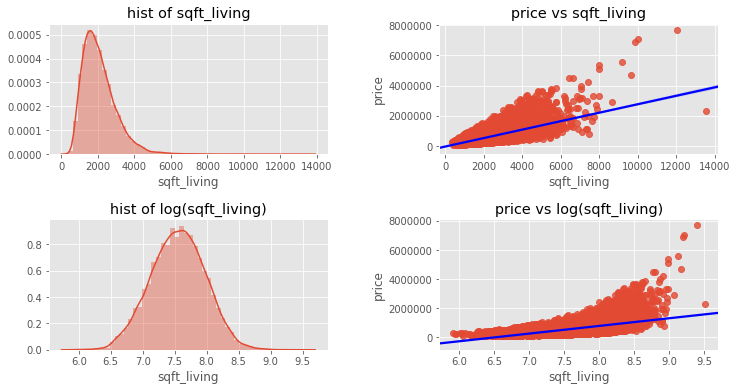

In [1215]:
# sqft_living
sqft_living = data_continuous['sqft_living']

fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

ax = fig.add_subplot(2, 2, 1)
sns.distplot(sqft_living,ax=ax)
plt.title('hist of sqft_living')
ax = fig.add_subplot(2, 2, 2)
sns.regplot(sqft_living,data['price'],ax=ax,line_kws={'color': 'blue'})
plt.title('price vs sqft_living')
ax = fig.add_subplot(2, 2, 3)
sns.distplot(np.log(sqft_living),ax=ax)
plt.title('hist of log(sqft_living)')
ax = fig.add_subplot(2, 2, 4)
sns.regplot(np.log(sqft_living),data['price'],ax=ax,line_kws={'color': 'blue'})
plt.title('price vs log(sqft_living)')

plt.show()

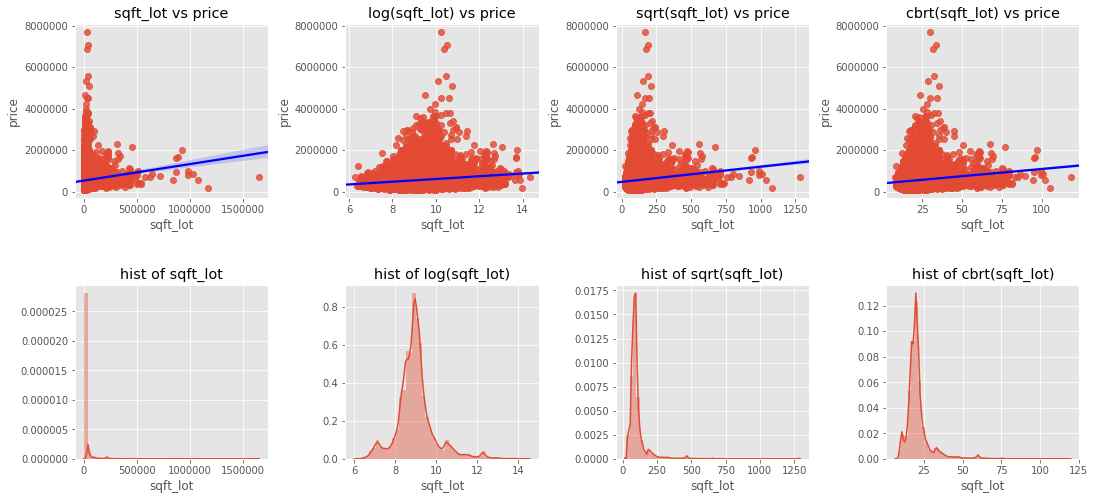

In [1216]:
# sqft_lot
def ls_hist_and_reg_plot(x,y):
    ''' Displays histogram and regression plot with various
        left-skew transformations for a given column
    
    Parameters:
        x (pd.Series): Series containing X axis data
        y (pd.Series): Series containing Y axis data
    
    Returns:
        None
    '''    
    fig = plt.figure(figsize=(18,8))
    fig.subplots_adjust(hspace=0.5, wspace=0.4)

    ax = fig.add_subplot(2, 4, 1)
    sns.regplot(x,y,ax=ax,line_kws={'color': 'blue'})
    plt.title('{} vs {}'.format(x.name,y.name))
    ax = fig.add_subplot(2, 4, 2)
    sns.regplot(np.log(x),y,ax=ax,line_kws={'color': 'blue'})
    plt.title('log({}) vs {}'.format(x.name,y.name))
    ax = fig.add_subplot(2, 4, 3)
    sns.regplot(np.sqrt(x),y,ax=ax,line_kws={'color': 'blue'})
    plt.title('sqrt({}) vs {}'.format(x.name,y.name))
    ax = fig.add_subplot(2, 4, 4)
    sns.regplot(np.cbrt(x),y,ax=ax,line_kws={'color': 'blue'})
    plt.title('cbrt({}) vs {}'.format(x.name,y.name))

    ax = fig.add_subplot(2, 4, 5)
    sns.distplot(x,ax=ax)
    plt.title('hist of {}'.format(x.name))
    ax = fig.add_subplot(2, 4, 6)
    sns.distplot(np.log(x),ax=ax)
    plt.title('hist of log({})'.format(x.name))
    ax = fig.add_subplot(2, 4, 7)
    sns.distplot(np.sqrt(x),ax=ax)
    plt.title('hist of sqrt({})'.format(x.name))
    ax = fig.add_subplot(2, 4, 8)
    sns.distplot(np.cbrt(x),ax=ax)
    plt.title('hist of cbrt({})'.format(x.name))
    plt.show()
    
ls_hist_and_reg_plot(data_continuous['sqft_lot'],data['price'])

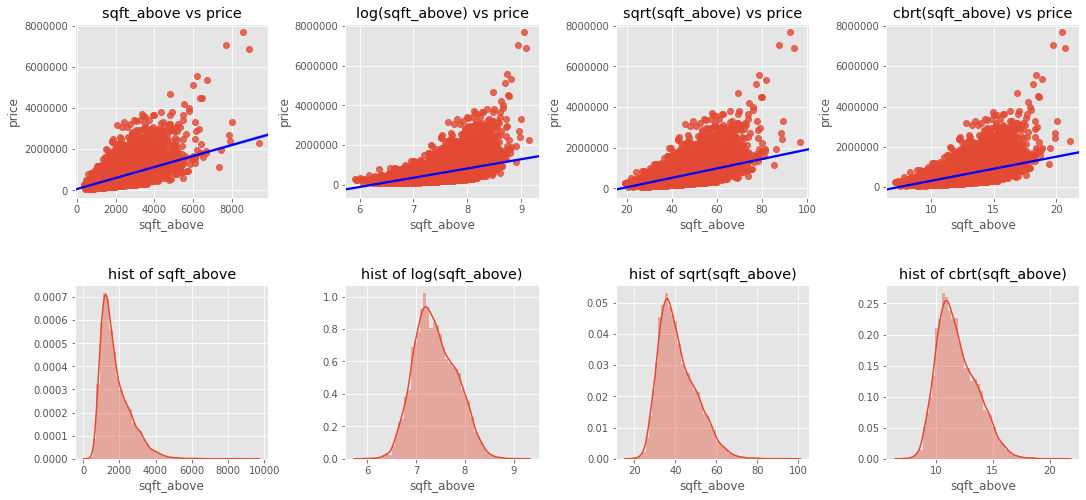

In [1217]:
ls_hist_and_reg_plot(data_continuous['sqft_above'],data['price'])

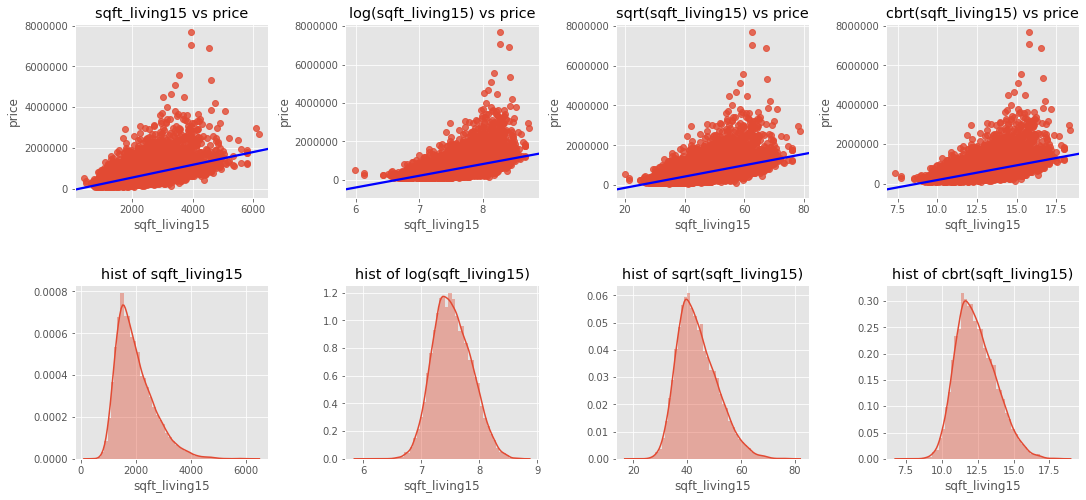

In [1218]:
ls_hist_and_reg_plot(data_continuous['sqft_living15'],data['price'])

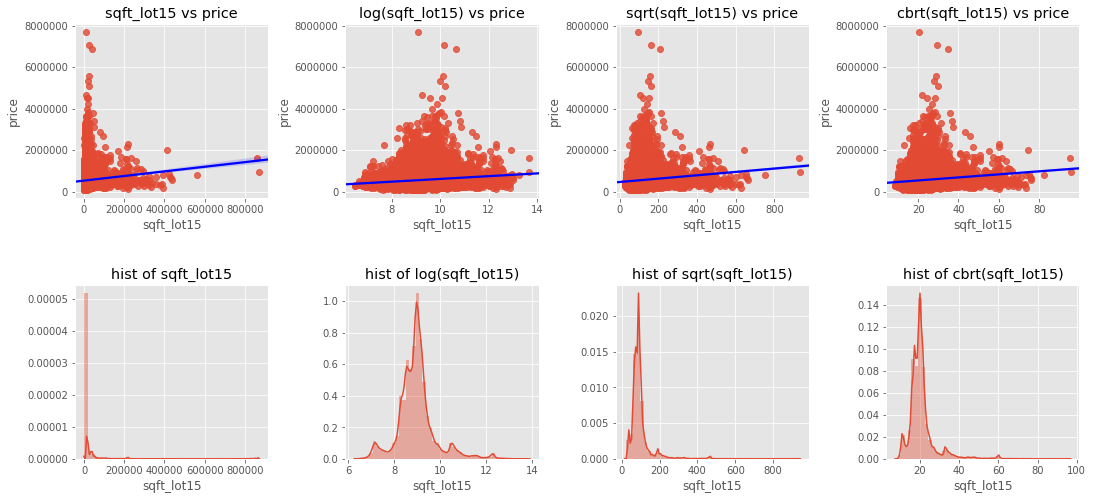

In [1219]:
ls_hist_and_reg_plot(data_continuous['sqft_lot15'],data['price'])

In [1220]:
# sqft_lot,sqft_lot15,sqft_above,sqft_living,sqft_living15 all get log transformations
    
# that leavs sqft_basement, yr_built','yr_renovated'
# let's handle sqft_basement

0    13250
Name: sqft_basement, dtype: int64


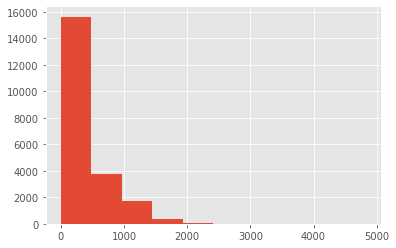

In [1221]:
print(data_continuous['sqft_basement'].value_counts()[:1])
data_continuous['sqft_basement'].hist();

In [1222]:
# since mostly no basements, maybe an engineered feature like this might work better?
has_basement = pd.Series([1 if x != 0 else 0 for x in data_continuous['sqft_basement']])
has_basement.name = 'has_basement'
has_basement.value_counts()

0    13250
1     8284
Name: has_basement, dtype: int64

In [1223]:
def compare_correlation(x1,x2,y):
    ''' prints a quick correlation report comparing
        any two features
    
    Parameters:
        x (pd.Series): series containing first feature
        x2 (pd.Series): series containing second feature
        y (pd.Series): series containing target feature
    
    Returns:
        None
    '''
    print('Correlation report:')
    cm = np.round(np.corrcoef([x1,x2],y),4)
    x1y = cm[0,2]
    x2y = cm[1,2]
    x1x2 = cm[0,1]
    print('{} vs {}: {}'.format(x1.name,y.name,x1y))
    print('{} vs {}: {}'.format(x2.name,y.name,x2y))
    print('{} vs {}: {}'.format(x1.name,x2.name,x1x2))

compare_correlation(has_basement,data_continuous['sqft_basement'],data['price'])

Correlation report:
has_basement vs price: 0.1776
sqft_basement vs price: 0.3191
has_basement vs sqft_basement: 0.8211


In [1224]:
# has_basement is weaker than sqft_basement, and they're pretty collinear
del has_basement
gc.collect()

130510

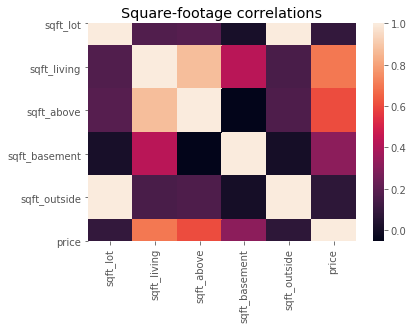

In [1225]:
# let's make sqft_outside feature by subtracting sqft_living from sqft_lot
sqft_outside = data_continuous['sqft_lot'] - data_continuous['sqft_living']
temp = data_continuous[['sqft_lot','sqft_living','sqft_above','sqft_basement']]
temp['sqft_outside'] = sqft_outside
temp['price'] = data['price']

corr = temp.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns).set_title('Square-footage correlations');

No surprise that there's a lot of collinearity here.  
`sqft_living` $=$ `sqft_lot` $-$ `sqft_outside`  
`sqft_above` $=$ `sqft_living` $-$ `sqft_basement`  
Let's take only `sqft_lot`, `sqft_above`, and `sqft_basement`, since those have great correlation with `price` and lowest multicollinearity.

In [1226]:
# now let's look at sqft_lot15 and sqft_living15
compare_correlation(data_continuous['sqft_lot15'],data_continuous['sqft_living15'],data['price'])

Correlation report:
sqft_lot15 vs price: 0.0832
sqft_living15 vs price: 0.5853
sqft_lot15 vs sqft_living15: 0.184


In [1227]:
# what about some relative area features?
sqft_living_relative = data_continuous['sqft_living'] - data_continuous['sqft_living15']                                                                   
print(np.round(np.corrcoef(sqft_living_relative,data['price']),4))

sqft_lot_relative = data_continuous['sqft_lot'] - data_continuous['sqft_lot15']
print(np.round(np.corrcoef(sqft_lot_relative,data['price']),4))

[[1.     0.4042]
 [0.4042 1.    ]]
[[1.     0.0508]
 [0.0508 1.    ]]


So let's just keep sqft_living15, drop the lot15 and forget the relative features.

In [1228]:
# now let's look at yr_renovation and yr_built
compare_correlation(data['yr_renovated'],data['yr_built'],data['price'])

Correlation report:
yr_renovated vs price: 0.118
yr_built vs price: 0.0543
yr_renovated vs yr_built: -0.2025


In [1229]:
# how about some engineered features?
house_age = data['date'].apply(lambda x: int(x.split()[0][-4:])) - data['yr_built']
house_age.name = 'house_age'
time_since_renovation = data['date'].apply(lambda x: int(x.split()[0][-4:])) - data['yr_renovated']
time_since_renovation.name = 'time_since_renovation'

compare_correlation(house_age,time_since_renovation,data['price'])

Correlation report:
house_age vs price: -0.0542
time_since_renovation vs price: -0.118
house_age vs time_since_renovation: -0.2021


### Quantized features

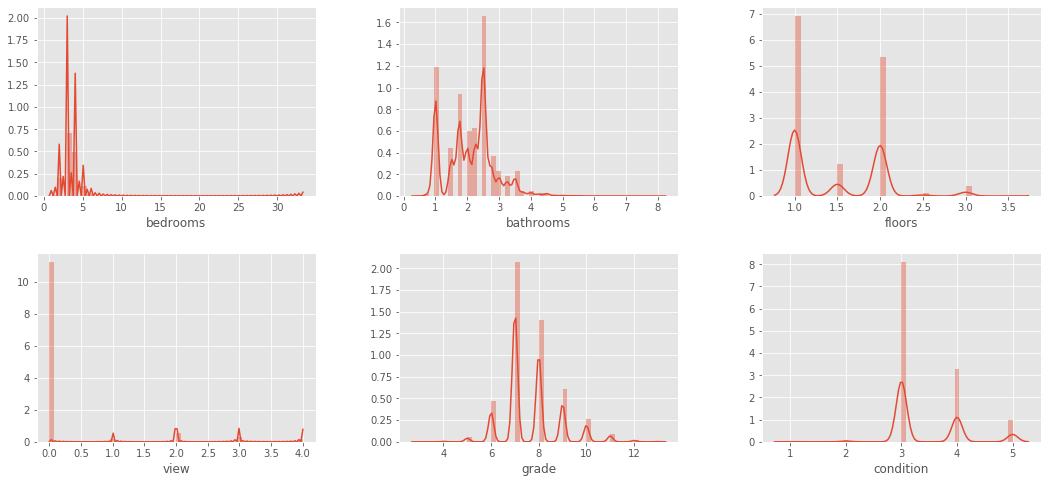

In [1230]:
fig = plt.figure(figsize=(18,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i,col in enumerate(data_quantized.columns):
    ax = fig.add_subplot(2, 3, i+1)
    sns.distplot(data_quantized[col],ax=ax)
plt.show()

Bedrooms is pretty much guassian, with a bunch of outliers.

In [1231]:
def ideal_qcut(x,y,min_q=2,max_q=9,verbose=False):
    ''' Finds ideal q value for cutting features into bins
    
    Parameters:
        x (pd.Series) : values to try cutting
        y (pd.Series) : values to regress against
        min_q (int,optional): minimum q value (default: 2)
        max_q (int,optional): maximum q value (default: 9)
        verbose (boolean): whether to read out q value results
        
    Returns:
        list: dictionaries containing correlation values per q value
    '''
    results = []
    for i in range(max_q - min_q + 1):
        temp = pd.qcut(x,q=i+min_q,duplicates='drop')
        temp = temp.astype('category').cat.codes
        if verbose:
            print("q = {}: {:.4}".format(i+min_q,np.corrcoef(temp,y)[0][1]))
        results.append({'q':i+min_q,
                        'correlation':np.corrcoef(temp,y)[0][1]})
    return results

In [1232]:
def quant_to_bin(x,y,verbose=True,report=True):
    ''' cuts quantized feature into best quantile bins
    
    Parameters:
        x (pd.Series): feature to cut
        y (pd.Series): target feature
        verbose (boolean): whether to plot distributions before and after
        report (boolean): whether to provide correlation report
        
    Returns:
        pd.Series: cat-encoded cut feature
    '''
    if verbose:
        # plot unaltered distribution
        fig = plt.figure(figsize=(18,6))
        fig.subplots_adjust(hspace=0.3, wspace=0.3)
        ax = fig.add_subplot(1, 2, 1)
        sns.distplot(x,ax=ax)
    
    # find ideal q value for cutting
    results = ideal_qcut(x,y)
    ideal_q = sorted(results,key=lambda x:x['correlation'],reverse=True)[0]['q']
    
    # cut and categorically encode
    cut = pd.qcut(x,q=ideal_q,duplicates='drop')
    cut = cut.astype('category').cat.codes
    cut.name = 'cut_{}'.format(x.name)
    
    if verbose:
        # plot altered distrubtion
        ax = fig.add_subplot(1, 2, 2)
        sns.distplot(cut,ax=ax)
        plt.show()

    if report:
        # print correlation report
        compare_correlation(x,cut,y)
    return cut

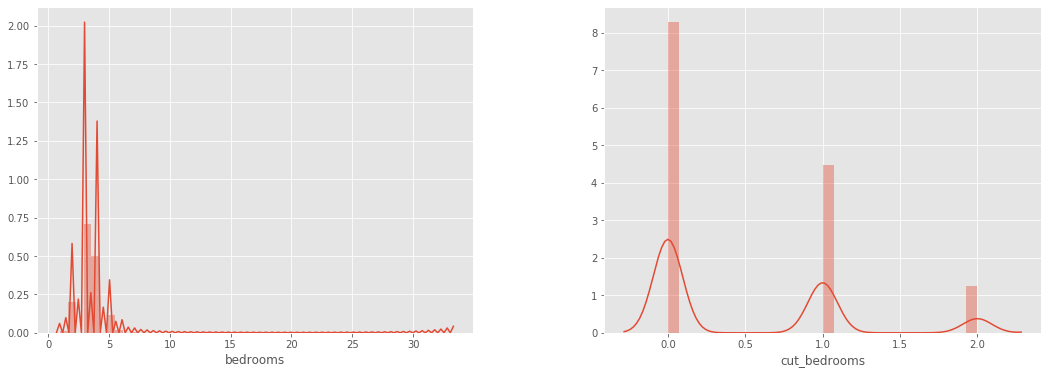

Correlation report:
bedrooms vs price: 0.3081
cut_bedrooms vs price: 0.3175
bedrooms vs cut_bedrooms: 0.8796


In [1233]:
# now let's try using the tools
bedrooms_cuts = quant_to_bin(data_quantized['bedrooms'],data['price'])

slight score improvement by cutting it. let's try another.

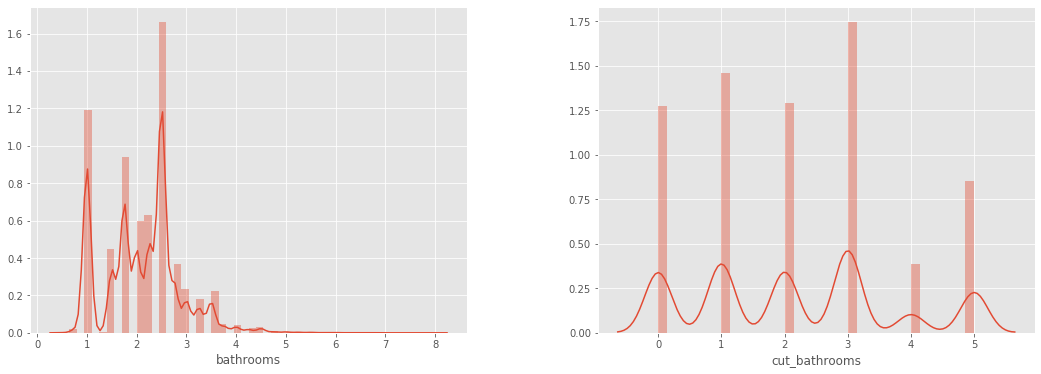

Correlation report:
bathrooms vs price: 0.5251
cut_bathrooms vs price: 0.4681
bathrooms vs cut_bathrooms: 0.9573


In [1234]:
bathrooms_cuts = quant_to_bin(data_quantized['bathrooms'],data['price'])

looks like we'd better not cut bathrooms

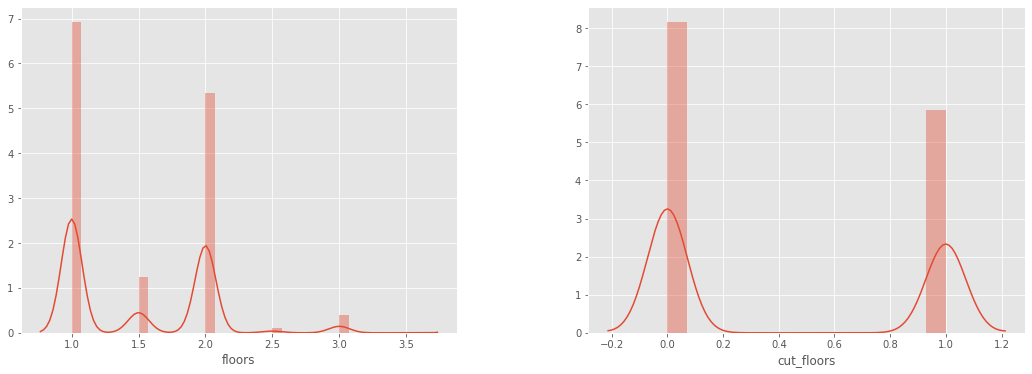

Correlation report:
floors vs price: 0.2571
cut_floors vs price: 0.2584
floors vs cut_floors: 0.9155


In [1235]:
floors_cuts = quant_to_bin(data_quantized['floors'],data['price'])

slight benefit by cutting floors

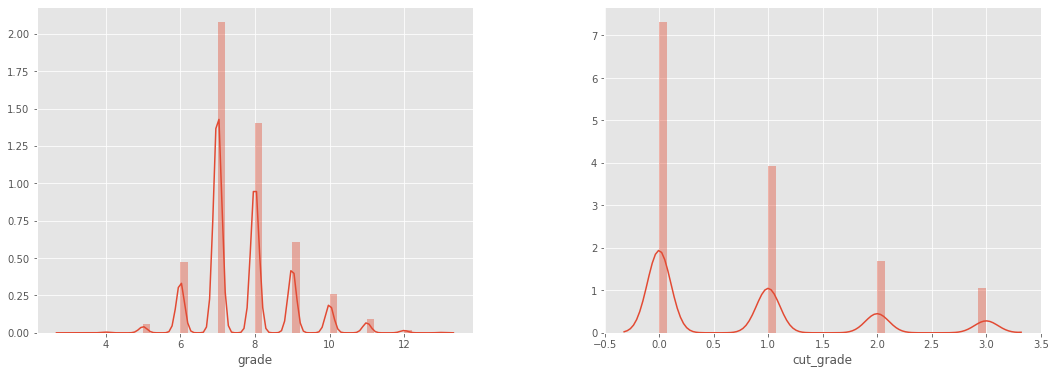

Correlation report:
grade vs price: 0.6683
cut_grade vs price: 0.6392
grade vs cut_grade: 0.9416


In [1236]:
grade_cuts = quant_to_bin(data_quantized['grade'],data['price'])

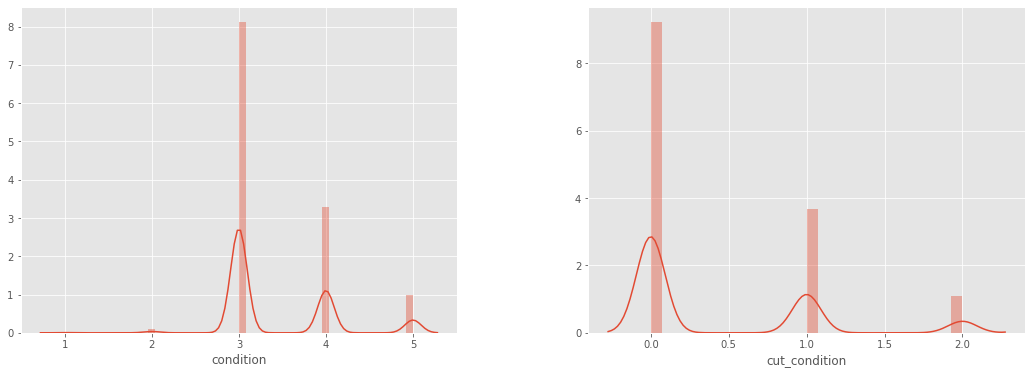

Correlation report:
condition vs price: 0.0354
cut_condition vs price: 0.0268
condition vs cut_condition: 0.9844


In [1237]:
condition_cuts = quant_to_bin(data_quantized['condition'],data['price'])

only use cut versions of bedrooms and floors

In [1238]:
# let's look at the rest: view, grade, condition, and bathrooms
for col in ['view','grade','condition','bathrooms']:
    corr = np.corrcoef(data_quantized[col],data['price'])[0,1]
    print("{} vs price: {:.4}".format(col,corr))

view vs price: 0.3957
grade vs price: 0.6683
condition vs price: 0.03539
bathrooms vs price: 0.5251


we can forget about condition. let's keep the rest for now.

## Feature engineering

### Neighborhoods
I suspect that the neighborhood and distance from nearest central buisness district may be important factors. Zipcodes could help with that, but they don't necessarily convey neighborhoods as experienced by residents.  

Instead, I'm going to drop zipcodes and use [this dataset I found online](https://gis-kingcounty.opendata.arcgis.com/datasets/neighborhood-centers-in-king-county-neighborhood-centers-point/data?page=5) to find each datapoint's nearest CBD and calculate the distance thereto.

In [1239]:
data.drop('zipcode',axis=1,inplace=True)
hoods = pd.read_csv('Neighborhood_Centers_in_King_County__neighborhood_centers_point.csv')
hoods.head(3)

,X,Y,OBJECTID,FEATURE_ID,CODE,NAME,ADDRESS,NEIGH_NUM,XCOORD,YCOORD,LONGITUDE,LATITUDE
0,-122.355548,47.723233,1,90001,Community Area/Business Center/Neighborhood,Bitter Lake Neighborhood,N 130th St & Greenwood Ave N,3,1.265776e+06,267518.406033,-122.355550,47.723232
1,-122.323274,47.708595,2,90002,Community Area/Business Center/Neighborhood,Northgate Neighborhood,NE Northgate Way & 5th Ave NE,28,1.273615e+06,262024.468858,-122.323276,47.708593
2,-122.295226,47.719280,3,90003,Community Area/Business Center/Neighborhood,Lake City Neighborhood,NE 125th & Lake City Way NE,21,1.280593e+06,265788.625044,-122.295228,47.719278


In [1243]:
from operator import itemgetter
from haversine import haversine # calculates distance given latitudes and longitudes

def find_cbd(df,hoods):
    ''' Finds nearest CBD and distance therefrom
    
    Parameters:
    df (pd.DataFrame): the King County Housing dataset
    hoods (pd.DataFrame): The Neighborhood Centers in King County dataset
    
    Returns:
    pd.DataFrame: a new dataframe containing nearest neighborhood and distance features
    
    '''
    nearest_hoods,dist_hoods = [],[]
    for row in tqdm(df.iterrows(),total=len(df)):
        lat = row[1]['lat']
        lon = row[1]['long']
        to_cbd = []
        for hood in hoods.iterrows(): # consider all neighborhoods
            dist = haversine((lat,lon),
                             (hood[1]['LATITUDE'],hood[1]['LONGITUDE']),
                             unit='mi')
            to_cbd.append({'CBD' : hood[1]['NAME'],
                           'DIST' : dist})
        sortd = sorted(to_cbd, key=itemgetter('DIST')) # sort by distance, ascending
        nearest_hoods.append(sortd[0]['CBD']) # nearest CBD
        dist_hoods.append(sortd[0]['DIST']) # distance thereto
    new_panda = pd.DataFrame()
    new_panda['nearest_hoods'] = nearest_hoods
    new_panda['dist_hoods'] = dist_hoods
    return new_panda

# saving
#hoods_data = find_cbd(data,hoods) # uncomment if saving
#hoods_data.to_csv('hoods_data.csv',index=False) # uncomment if saving

# loading
hoods_data = pd.read_csv('hoods_data.csv') # uncomment if loading

# join neighborhood data to the primary dataframe
data = pd.concat([data,hoods_data],join='inner',axis=1)

`nearest_hoods` will need to be numerically indexed.

In [1244]:
data[['nearest_hoods','dist_hoods','price']].head()

,nearest_hoods,dist_hoods,price
0,Rainier Beach Neighborhood,1.032990,221900.0
1,Northgate Neighborhood,0.879959,538000.0
2,Finn Hill Neighborhood,0.741188,180000.0
3,Morgan Junction Neighborhood,1.684835,604000.0
4,Eastgate Neighborhood,5.275227,510000.0


In [1245]:
data['nearest_hood'] = data['nearest_hoods'].astype('category')
data['nearest_hood'] = data['nearest_hood'].cat.codes # numerically index
data.drop('nearest_hoods',axis=1,inplace=True)
data[['nearest_hood','dist_hoods','price']].head()

,nearest_hood,dist_hoods,price
0,32,1.032990,221900.0
1,30,0.879959,538000.0
2,13,0.741188,180000.0
3,25,1.684835,604000.0
4,11,5.275227,510000.0


### Nearest neighbors
The dataset came with two features based on other datapoints: `sqft_lot15` and `sqft_living15`, which are the mean lot and living areas (respectively) for the 15 nearest properties. Earlier, we saw that `sqft_lot15` wasn't especially correlated with target `price` (0.083), perhaps because lot sizes in urban areas tend to be the same, by region and zoning. On the other hand, `sqft_living15` was fairly correlated (0.585). This makes me wonder if I could extract other useful features out of regional information.  

### Metrics of the neighborhood
First I'll write a function to get metrics per neighborhood. Then we can create features relative to the neighborhoods'.

In [ ]:
def neighborhood(df,coi,metric):
    ''' returns an array of the metric of the column-of-interest per row
    Parameters:
        df (pd.Dataframe): the dataframe containing columns `nearest_hood` and the coi
        coi (str): the name of the column-of-interest in df
        metric (str {'min','max','std','mean','median','mode'}): the metric to use
    Returns:
        pd.Series: array containing the metric of `coi` per row
    '''
    gb = df.groupby(['nearest_hood'])[coi]
    if metric == 'min':
        gb = gb.min()
    elif metric == 'max':
        gb = gb.max()
    elif metric == 'std':
        gb = gb.std()
    elif metric == 'mean':
        gb = gb.mean()
    elif metric == 'median':
        gb = gb.median()
    else:
        print('metric must equal one of: \'min\',\'max\',\'std\',\'mean\',\'median\'')
    return data['nearest_hood'].apply(lambda x: gb[x])

In [ ]:
data['mean_hood_price'] = neighborhood(data,'price','mean')
display(data[['nearest_hood','mean_hood_price']].tail())
print("correlated to price: {}".format(np.corrcoef(data['mean_hood_price'],data['price'])[0,1]))

Well, that didn't work out as well as I'd hoped.

### Metrics of 10 nearest neighbors
I have no way of knowing if this datatset includes all houses, nor whether it includes all the houses used in calculating `sqft_living15` and `sqft_lot15`. Even if it did, I've dropped some rows with NaNs. For that reason, I'm only going to average over the nearest 10 neighbors.

I'll begin by making a column of arrays containing the `id` of the 10 nearest neighbors, that way I'll only have to find them once; I won't have to iterate through the whole dataframe every time I want a metric.

In [ ]:
def find_nearest_n(df,n):
    ''' finds nearest n neighbors to each property in df
    
    Parameters:
        df (pd.DataFrame): the King County Housing dataset
        n (int): number of nearest neighbors to record
        
    Returns:
        pd.Series: series of arrays of IDs of nearest n houses
    '''
    subset = df[['id','lat','long']]
    n_neighbors = []
    for a_row in tqdm(subset.iterrows(),total=len(df)):
        subset['working_lat'] = subset['lat'].apply(lambda x: x - a_row[1]['lat'])
        subset['working_long'] = subset['long'].apply(lambda x: x - a_row[1]['long'])
        sortd = subset.sort_values(['working_lat','working_long'])
        selfref = sortd.loc[sortd['id'] == a_row[1]['id']].index
        sortd.drop(selfref,inplace=True)
        n_neighbors.append(sortd.iloc[:n]['id'].ravel())
    return pd.Series(n_neighbors)

In [ ]:
#data['nearest_ids'] = find_nearest_n(data,10)

### Cultural spaces within a short distance
I want it to be close enough to be directly influential, yet far enough away to grab enough to count.

In [ ]:
cultural_spaces = pd.read_csv('Seattle_Cultural_Space_Inventory.csv')
cs_before = len(cultural_spaces)
cultural_spaces.head(3)

In [ ]:
# chop out the ones lacking latitude/longitude
cultural_spaces = cultural_spaces.loc[cultural_spaces['Location'].isna() != True]
# check for other relevant nans
print("Cultural spaces with lat/long: {} of {}".format(len(cultural_spaces),cs_before))

cultural_cats = cultural_spaces['Dominant Discipline'].value_counts().index
cultural_spaces = cultural_spaces.loc[cultural_spaces['Dominant Discipline'] != cultural_cats[-1]]
cultural_spaces = cultural_spaces.loc[cultural_spaces['Dominant Discipline'] != cultural_cats[-2]]
# quick nan removal
indices = cultural_spaces.loc[cultural_spaces['Dominant Discipline'].isna()]
cultural_spaces.drop(indices.index, inplace=True)
print('Cultural spaces with lat/long and dominant discipline: {}'.format(len(cultural_spaces)))

In [ ]:
def find_culture(df,cdf,max_dist):
    ''' Counts cultural spaces by type within specified distance
    
    Parameters:
    df (pd.DataFrame): the King County Housing dataset
    cdf (pd.DataFrame): the Seattle Cultural Space Inventory dataset
    max_dist (float): maximum distance in miles between house and cultural center
    
    Returns:
    pd.Series: the number of cultural centers within specified distance per house
    
    '''
    precision = ((max_dist * 1.61) / 1.1) * 0.01 # mi to km per lat/lon 2nd decmial place
    cols = cdf['Dominant Discipline'].value_counts().keys()
    cultural_results = pd.DataFrame(columns=cols)
    for row in tqdm(df.iterrows(),total=len(df)):
        lat = row[1]['lat']
        lon = row[1]['long']
        # narrow search area to save time, cuts ~75% computation time
        near_lats = cdf[abs(cdf['Latitude'] - lat) <= precision]
        near_lons = near_lats[abs(near_lats['Longitude'] - lon) <= precision]
        # use haversine at max_dist to narrow further
        counter = pd.Series(np.zeros((len(cols))),index=cols)
        for center in near_lons.iterrows():
            c_lat = center[1]['Latitude']
            c_lon = center[1]['Longitude']
            dist = haversine((lat,lon),
                             (c_lat,c_lon),
                             unit='mi')
            if dist <= max_dist:
                counter[center[1]['Dominant Discipline']] += 1
        cultural_results = cultural_results.append(counter,ignore_index=True)
    return cultural_results

In [ ]:
# the distribution for cultural spaces within 2 miles was right-skewed,
# indicating it might be better to poll further away. let's try 4 miles.

# for saving
#cultural_counts_df = find_culture(data,cultural_spaces,3)
#cultural_counts_df.to_csv('num_cultural_spaces_1mi.csv',index=False)

# for loading
cultural_counts_df = pd.read_csv('num_cultural_spaces_3mi.csv')

cultural_counts_df.head(3)

In [ ]:
temp = cultural_counts_df
temp['Total count'] = temp.sum(axis=1)
temp['Price'] = data['price']

corr = temp.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns).set_title('Cultural center correlations');

As you can see from the plots, the proximity of cultural centers probably makes almost no difference in housing sale prices.

In [1352]:
# now try School_Sites_in_King_County__schsite_point.csv
schools_df = pd.read_csv('School_Sites_in_King_County__schsite_point.csv')
schools_before = len(schools_df)
schools_df.head(3)

,X,Y,OBJECTID,FEATURE_ID,ESITE,CODE,NAME,ABB_NAME,ADDRESS,ZIPCODE,LONG_CEN,LAT_CEN,SCH_CLASS,DISTRICT,PIN,MAJOR,MINOR,FEATUREDES,OSPI_CODE
0,-122.152303,47.608461,1,207,80,School-High,Sammamish High School,Sammamish,100 140th Ave SE,98005,-122.152305,47.608458,10.0,BELLEVUE,3.425059e+09,342505.0,9019.0,School-High,3282.0
1,-122.205415,47.768906,2,263,113,School-Elementary,Saint Brendan Catholic School,Saint Brendan,10049 NE 195th St,98011,-122.205416,47.768905,20.0,NORTHSHORE,5.260591e+08,52605.0,9084.0,School-Elementary,0.0
2,-122.348454,47.525265,3,884,527409,School-Elementary,Highland Park Elementary School,Highland Park,1012 SW Trenton St,98106,-122.348456,47.525263,10.0,SEATTLE,7.972603e+09,797260.0,3210.0,School-Elementary,2269.0


In [1353]:
schools_df['CODE'].value_counts()

School-Elementary               345
School-Junior High/Middle        80
School-High                      73
School-Alternative               64
School-Other Facility            32
School-College or University     31
School-K-12                      17
Name: CODE, dtype: int64

In [ ]:
def find_schools(df,sdf):
    ''' Finds distance to nearest school for each house
    
    Parameters:
        df (pd.DataFrame): the King County Housing dataset
        cdf (pd.DataFrame): the School Sites in King County dataset
    
    Returns:
        array: distances to schools for each house in df
    '''
    school_types = sdf['CODE'].unique()
    dists_to_schools = pd.DataFrame(columns=school_types)
    for row in tqdm(df.iterrows(),total=len(df)):
        school_distances = pd.Series(index=school_types)
        lat = row[1]['lat']
        lon = row[1]['long']
        for col in school_types:
            subset = sdf.loc[sdf['CODE'] == col]
            nearest = min(subset.iterrows(),
                          key=lambda p: haversine((p[1]['Y'],p[1]['X']),
                                                  (lat,lon),unit='mi'))
            school_distances[col] = haversine((nearest[1]['Y'],nearest[1]['X']),
                                              (lat,lon),unit='mi')
        dists_to_schools = dists_to_schools.append(school_distances,
                                                   ignore_index=True)
    return dists_to_schools

In [1354]:
# saving
#dists_to_schools = find_schools(data,schools_df)
#dists_to_schools.to_csv('distances_to_schools_by_type.csv',index=False)

# loading
dists_to_schools = pd.read_csv('distances_to_schools_by_type.csv')

dists_to_schools.head(3)

,School-High,School-Elementary,School-Alternative,School-Junior High/Middle,School-College or University,School-K-12,School-Other Facility
0,0.980736,0.130673,2.019210,1.730659,3.606699,2.525321,2.668727
1,0.885230,0.245892,0.559668,0.628985,1.621822,1.300072,1.948318
2,0.510869,0.111689,1.236571,1.236571,1.005689,2.114384,3.869594


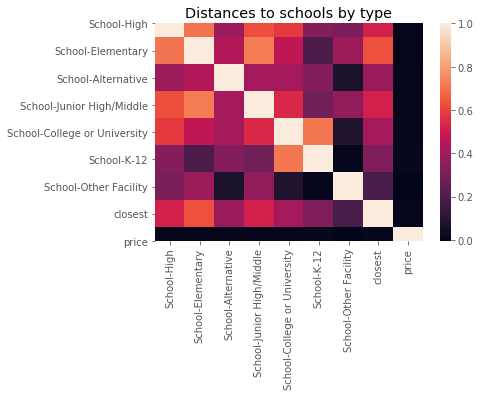

In [1355]:
temp = dists_to_schools
temp['closest'] = temp.min(axis=1)
temp['price'] = data['price']

corr = temp.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns).set_title('Distances to schools by type');

In [ ]:
# now let's do crime
crime_df = pd.read_csv('King_County_Sheriff_s_Office.csv')
crime_df.head()

### Apply and Cleanup

In [1252]:
# we apply the changes to `df`, so `data` stays clean for exploring
df = data.copy()
to_log = ['sqft_lot','sqft_lot15','sqft_above','sqft_living','sqft_living15']
for col in to_log:
    df[col] = np.log(df[col])
     
#df.drop('sqft_living',axis=1,inplace=True) # probably not the thing to do
#df.drop('sqft_lot15',axis=1,inplace=True)

#one_hot bins
'''
bedrooms_cuts = pd.get_dummies(bedrooms_cuts,
                               prefix='bedrooms_',
                               drop_first=drop_first)
df.drop('bedrooms',axis=1,inplace=True)
df = pd.concat([df,bedrooms_cuts],axis=1)

# bin floors
floors_cuts = pd.get_dummies(floors_cuts,
                               prefix='floors_',
                               drop_first=drop_first)
df.drop('floors',axis=1,inplace=True)
df = pd.concat([df,floors_cuts],axis=1)

# now let's add nearest_hoods data
'''

"\nbedrooms_cuts = pd.get_dummies(bedrooms_cuts,\n                               prefix='bedrooms_',\n                               drop_first=drop_first)\ndf.drop('bedrooms',axis=1,inplace=True)\ndf = pd.concat([df,bedrooms_cuts],axis=1)\n\n# bin floors\nfloors_cuts = pd.get_dummies(floors_cuts,\n                               prefix='floors_',\n                               drop_first=drop_first)\ndf.drop('floors',axis=1,inplace=True)\ndf = pd.concat([df,floors_cuts],axis=1)\n\n# now let's add nearest_hoods data\n"

In [1253]:
# Anything else to drop?
to_drop = ['id','date','yr_built','yr_renovated','zipcode','lat','long']
for col in to_drop:
    df.drop(col,axis=1,inplace=True)

KeyError: "['zipcode'] not found in axis"

In [1254]:
df['nearest_hood'] = data['nearest_hood']
#df['cultural_counts'] = cultural_counts_array

### Tool to check stuff

In [1255]:
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def test(X,y):
    X_train,X_test,y_train,y_test = tts(X,y,test_size=0.3,random_state=31)
    lr = LinearRegression().fit(X_train,y_train)
    preds = lr.predict(X_test)
    print("R-squared score: {}".format(r2_score(y_test,preds)))

In [1256]:
X_base = df.copy()
y_base = X_base.pop('price')
test(X_base,y_base)

R-squared score: 0.640172434988348


In [1257]:
X_extra = df.copy()
#X_extra.drop('nearest_hood',axis=1,inplace=True)
X_extra = pd.concat([X_extra,np.log(dists_to_schools)],join='inner',axis=1)
X_extra = pd.concat([X_extra,np.cbrt(cultural_counts_df)],join='inner',axis=1)
y_extra = X_extra.pop('price')
X_extra.pop('Price')
test(X_extra,y_extra)

R-squared score: 0.6959366854051234


### Outlier removal
There are many ways to remove outliers.

In [ ]:
X_bl = df.copy()
X_bl.drop('nearest_hood',axis=1,inplace=True)
y_bl = X_bl.pop('price')
test(X_bl,y_bl)


In [ ]:
X_if = df.copy()
#X_if.drop('nearest_hood',axis=1,inplace=True)
y_if = X_if.pop('price')

from sklearn.ensemble import IsolationForest

clf = IsolationForest(behaviour='new', contamination=0.01)

# only the columns that can have outlier values


# -1 indicates outlier
X_if['cleaver'] = clf.fit_predict(X_if)
indices = X_if[X_if['cleaver'] == -1].index
X_if.drop(indices, inplace=True)
y_if.drop(indices, inplace=True)
X_if.drop('cleaver',axis=1,inplace=True)
test(X_if,y_if)

In [ ]:
X_iqr = df.copy()
y_iqr = X_iqr.pop('price')
#X_iqr.drop('nearest_hood',axis=1,inplace=True)
Q1 = X_iqr.quantile(0.25)
Q3 = X_iqr.quantile(0.75)
IQR = Q3 - Q1
indices = (X_iqr < (Q1 - 3.0 * IQR)) | (X_iqr > (Q3 + 3.0 * IQR))
X_iqr['cleaver'] = indices.any(axis=1)
indices = X_iqr[X_iqr['cleaver'] == True].index
X_iqr.drop(indices, inplace=True)
y_iqr.drop(indices, inplace=True)
X_iqr.drop('cleaver',axis=1,inplace=True)
test(X_iqr,y_iqr)

In [ ]:
# clean-up
to_del = [X_bl,y_bl,X_if,y_if,X_iqr,y_iqr,Q1,Q3,IQR]
for thing in to_del:
    del thing
gc.collect()

correlation matrix time

In [ ]:
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
est.pvalues